In [1]:
import os
import pyopencl as pcl
import numpy as np

# let's try to find available devices
platforms = pcl.get_platforms()
for p in platforms:
    devs = p.get_devices()
    for d in devs:
        print(d.name, pcl.device_type.to_string(d.type), d.global_mem_size / 10**9)

# let's select the AMD radeon card in this case
dev=None
for p in pcl.get_platforms():
    devs = p.get_devices()
    for d in devs:
        if pcl.device_type.to_string(d.type) == 'GPU' and (d.global_mem_size / 10**9) > 2.0:
            dev = d
            
# make the opencl context
# cntx = pcl.create_some_context()
cntx = pcl.Context(devices=[dev])
queue = pcl.CommandQueue(cntx, device=dev)

In [3]:
# get the location of the opencl code
ols_cl_file = os.path.join('..', 'src', 'cl', 'ols_cost.cl')
os.path.isfile(ols_cl_file)

True

In [123]:
# build the kernel
with open(ols_cl_file, 'r') as f:
    programs = pcl.Program(cntx, f.read()).build()
    f.seek(0)
    print(f.read())

// #include <math.h>

float dotproduct(__global float * a, __global float * b, int size)
{
  float out = 0.0;

  for (int i = 0; i<size; i++){
    out += a[i] * b[i];
  }

  return out;

}


float ols_cost_loc(__global float * x, __global float * theta, float y, int xsize)
{
  // cost = \sum (x * theta - y)**2

  float estimate = dotproduct(x, theta, xsize);
  float cost = powf(estimate - y, 2.0);

  return cost;
}

float compute_avg(__global float * vector, int size)
{
  float sum = 0.0;
  for(int i = 0; i < size; i++){
    sum += vector[i];
  }

  float avg = sum;
  return avg;
}

float compute_sum(__global float * array, int size){
  float sum = 0.0;
  for(int i = 0; i < size; i++){
    sum += array[i];
  }
  return sum;
}



__kernel void ols_cost(__global float * X, __global float * theta, __global float * y, __global float * cost, const int nrows, const int ncols)
{
  // here we are taking X to be a 2 dimensional array, tranlated from a row-majored indexed array
  // theta is a 1

/Users/antalek/anaconda/envs/ENVPy3/lib/python3.5/site-packages/pyopencl/cffi_cl.py:1476: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [104]:

X = np.random.normal(size=(100, 2))
X[:, 0] = 1.0 # this is for the intercept
theta = np.random.normal(size=(2,1))

y = X.dot(theta) + np.random.normal(scale=0.06, size=(100,1))

In [105]:
X.dot(theta).shape, y.shape

((100, 1), (100, 1))

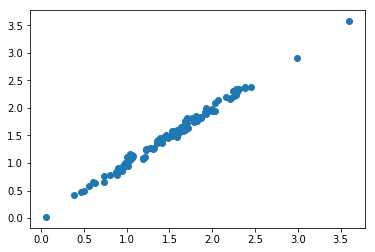

In [106]:
import matplotlib.pyplot as plt
plt.scatter(X.dot(theta), y)
plt.show()

In [107]:
# calculate the cost myself

def cost(X, theta, y):
    est = X.dot(theta)
    cost = ((est - y)**2.0).sum()
    return cost

In [108]:
X = X.astype(np.float32)
theta = theta.astype(np.float32)
y = y.astype(np.float32)

In [109]:
my_cost = cost(X, theta, y)

In [110]:
my_cost = np.float32(my_cost)
my_cost

0.28029475

In [111]:
#ok let's see if this works

In [112]:
X.shape, theta.shape, y.shape

((100, 2), (2, 1), (100, 1))

In [113]:
test_cost = -100.0 * np.ones(shape=y.shape, dtype=np.float32)

In [114]:
# test_cost

In [115]:
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y)
cost_out = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=test_cost.nbytes)

In [116]:
execute_event = programs.ols_cost(queue,
                                  X.shape,
                                  None, 
                                  X_buf,
                                  theta_buf,
                                  y_buf,
                                  cost_out,
                                  np.int32(X.shape[0]),
                                  np.int32(X.shape[1]))

In [117]:
execute_event.wait()

In [118]:
pcl.enqueue_copy(queue, test_cost, cost_out).wait()

In [119]:
test_cost

array([[  0.00000000e+00],
       [  1.84160401e-03],
       [  2.73189694e-03],
       [  7.13335397e-03],
       [  6.84228944e-05],
       [  5.42364796e-06],
       [  1.06286881e-02],
       [  1.43998826e-03],
       [  1.11537268e-02],
       [  1.59237662e-03],
       [  4.48683184e-03],
       [  4.22530202e-03],
       [  5.39127365e-03],
       [  6.26569754e-03],
       [  1.19687328e-02],
       [  7.68708924e-05],
       [  1.23346958e-03],
       [  1.02432463e-02],
       [  2.60256726e-04],
       [  4.67522116e-03],
       [  6.76495663e-04],
       [  1.40077644e-03],
       [  2.87395180e-03],
       [  3.73539608e-03],
       [  1.24911014e-02],
       [  2.39720708e-03],
       [  2.32355134e-03],
       [  1.98848033e-03],
       [  1.31732877e-02],
       [  3.51873692e-04],
       [  1.18951825e-03],
       [  1.23449555e-03],
       [  8.88862927e-03],
       [  1.64850056e-03],
       [  1.15664315e-03],
       [  9.27545898e-07],
       [  1.37961961e-05],
 

In [120]:
my_cost

0.28029475

In [121]:
test_cost.sum()

0.27808297

In [122]:
test_cost[0]

array([ 0.], dtype=float32)

In [ ]:
# hey it works!
# now I need to see if there is some way to compute the sum on the gpu and get that number
# instead of transfering the data back and then computing the sum....